# Slice interpolation for labels in zarpaint

## Resources

* Paper:  Raya and Udupa "Shape-Based Interpolation of Multidimensional Objects" IEEE TRANSACTIONS ON MEDICAL IMAGING, VOL. 9, NO. I , MARCH 1990
* [This StackOverflow post](https://stackoverflow.com/questions/48818373/interpolate-between-two-images) (not well executed for nd, but useful to read anyway)


## Set up some example data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import napari

In [3]:
viewer = napari.Viewer()
viewer.open_sample('napari', 'cells3d')
membrane_layer = viewer.layers[0]
nuclei_layer = viewer.layers[1]

Traceback (most recent call last):
  File "/Users/genevieb/mambaforge/envs/zarpaint/lib/python3.9/site-packages/magicgui/widgets/_bases/value_widget.py", line 57, in _on_value_change
    self.changed.emit(value)
  File "psygnal/_signal.py", line 682, in psygnal._signal.SignalInstance.emit
  File "psygnal/_signal.py", line 724, in psygnal._signal.SignalInstance._run_emit_loop
  File "psygnal/_signal.py", line 725, in psygnal._signal.SignalInstance._run_emit_loop
  File "psygnal/_signal.py", line 745, in psygnal._signal.SignalInstance._run_emit_loop
  File "/Users/genevieb/mambaforge/envs/zarpaint/lib/python3.9/site-packages/toolz/functoolz.py", line 306, in __call__
    return self._partial(*args, **kwargs)
  File "/Users/genevieb/mambaforge/envs/zarpaint/lib/python3.9/site-packages/zarpaint/_zarpaint.py", line 20, in _set_default_labels_path
    source_image = source_image_event.value
AttributeError: 'Image' object has no attribute 'value'


In [129]:
# # numpy label data
# single_nuclei_label = tifffile.imread('single-nuclei-label.tif')
# viewer.add_labels(single_nuclei_label)
# label_layer = viewer.layers[-1]
# labels = label_layer.data

## Manually create labels with zarpaint GUI

1. Plugins > zarpaint > create labels
2. Create a new zarr file called "mylabels.zarr"
3. Click "Run" in the zarpaint widget
4. Label the same nucleus at two different slices (take note of which slice numbers)

In [4]:
# Make note of which image slices you labelled
slice_index_1 = 30
slice_index_2 = 38

## Exploring the tensorstore labels

In [5]:
# after you have done the manual steps above, run this cell
label_layer = viewer.layers[-1]
ts = label_layer.data  # tensorstore data for the labels
print(ts)

TensorStore({
  'context': {
    'cache_pool': {},
    'data_copy_concurrency': {},
    'file_io_concurrency': {},
  },
  'driver': 'zarr',
  'dtype': 'uint32',
  'kvstore': {'driver': 'file', 'path': 'labels.zarr/'},
  'metadata': {
    'chunks': [1, 128, 128],
    'compressor': {
      'blocksize': 0,
      'clevel': 5,
      'cname': 'lz4',
      'id': 'blosc',
      'shuffle': 1,
    },
    'dimension_separator': '.',
    'dtype': '<u4',
    'fill_value': 0,
    'filters': None,
    'order': 'C',
    'shape': [60, 256, 256],
    'zarr_format': 2,
  },
  'transform': {
    'input_exclusive_max': [[60], [256], [256]],
    'input_inclusive_min': [0, 0, 0],
  },
})


In [106]:
print(ts[slice_index_1])
print("")
print("numpy array values:\n")
print(np.asarray(ts[slice_index_1]))


TensorStore({
  'context': {
    'cache_pool': {},
    'data_copy_concurrency': {},
    'file_io_concurrency': {},
  },
  'driver': 'zarr',
  'dtype': 'uint32',
  'kvstore': {'driver': 'file', 'path': 'mylabels.zarr/'},
  'metadata': {
    'chunks': [1, 128, 128],
    'compressor': {
      'blocksize': 0,
      'clevel': 5,
      'cname': 'lz4',
      'id': 'blosc',
      'shuffle': 1,
    },
    'dimension_separator': '.',
    'dtype': '<u4',
    'fill_value': 0,
    'filters': None,
    'order': 'C',
    'shape': [60, 256, 256],
    'zarr_format': 2,
  },
  'transform': {
    'input_exclusive_max': [[256], [256]],
    'input_inclusive_min': [0, 0],
    'output': [{'offset': 30}, {'input_dimension': 0}, {'input_dimension': 1}],
  },
})

numpy array values:

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


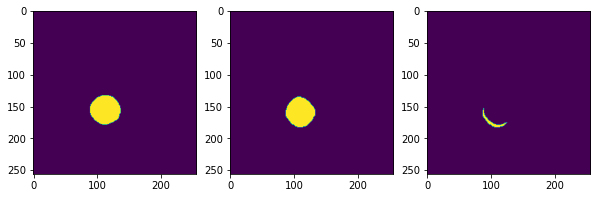

In [6]:
image_1 = np.asarray(ts[slice_index_1])
image_2 = np.asarray(ts[slice_index_2])
diff = image_1 - image_2

fig, ax = plt.subplots(ncols=3, figsize=(10,3))
ax[0].imshow(image_1)
ax[1].imshow(image_2)
ax[2].imshow(diff)


## Functions

In [7]:
# These functions are only used for this notebook, not for zarpaint
# It's convenient to have an easy way to delete label scribbling

def erase_slices(label_layer, slice_index_1, slice_index_2, interp_dim=0):
    """Erase label data on slices between slice_index_1 (inclusive),
    and slice_index_2 (non-inclusive, same as the python slicing syntax)."""
    for slice_number in range(slice_index_1, slice_index_2):
        slices = [slice(None) for _ in label_layer.data.shape]
        slices[interp_dim] = slice_number
        label_layer.data[slices] = 0
    label_layer.refresh()

    
def erase_all_slices(label_layer):
    for i in label_layer.data:
        i[...] = 0
    label_layer.refresh()  # refresh current view

These functions are for zarpaint...

In [15]:
import numpy as np
from scipy.interpolate import interpn
from scipy.ndimage import distance_transform_edt


def distance_transform(image):
    """Distance transform for a boolean image.
    
    Returns positive values inside the object,
    and negative values outside.
    """
    image = image.astype(bool)
    edt = distance_transform_edt(image) - distance_transform_edt(~image)
    return edt


def point_and_values(image_1, image_2, interp_dim=0):
    edt_1 = distance_transform(image_1)
    edt_2 = distance_transform(image_2)
    values = np.stack([edt_1, edt_2], axis=interp_dim)
    points = tuple([np.arange(i) for i in values.shape])
    return points, values


def xi_coords(shape, percent=0.5):
    slices = [slice(0, i) for i in shape]
    xi = np.moveaxis(np.mgrid[slices], 0, -1).reshape(np.prod(shape), len(shape))
    xi = xi = np.c_[np.full((np.prod(shape)), percent), xi]
    return xi


def slice_iterator(slice_index_1, slice_index_2):
    intermediate_slices = np.arange(slice_index_1 + 1, slice_index_2)
    n_slices = slice_index_2 - slice_index_1 + 1  # inclusive
    stepsize = 1 / n_slices
    intermediate_percentages = np.arange(0 + stepsize, 1, stepsize)
    return zip(intermediate_slices, intermediate_percentages)


def interpolated_slice(percent, points, values, interp_dim=0, method='linear'):
    # Find the original image shape
    img_shape = list(values.shape)
    del img_shape[interp_dim]
    # Calculate the interpolated slice
    xi = xi_coords(img_shape, percent=percent)
    interpolated_img = interpn(points, values, xi, method=method)
    interpolated_img = np.reshape(interpolated_img, img_shape) > 0
    return interpolated_img
    

In [13]:
# ## First draft, simply returns a numpy stack of the interpolated slices

# def interpolate_between_slices(image_1, image_2, slice_index_1, slice_index_2, interp_dim=0, method='linear'):
#     if slice_index_1 > slice_index_2:
#         image_1, image_2 = image_2, image_1
#         slice_index_1, slice_index_2 = slice_index_2, slice_index_1
#     ####
#     # possible extension, handle all label ids separately
#     label_id = 1
#     image_1 = image_1.astype(bool)
#     image_2 = image_2.astype(bool)
#     ####
#     edt_1 = distance_transform(image_1)
#     edt_2 = distance_transform(image_2)
#     values = np.stack([edt_1, edt_2], axis=interp_dim)
#     points = tuple([np.arange(i) for i in values.shape])

#     output = []
#     for slice_number, percentage in slice_iterator(slice_index_1, slice_index_2):
#         interpolated_img = interpolated_slice(percentage, points, values, interp_dim=interp_dim, method='linear')
#         output.append(interpolated_img)
#     output = np.array(output)
#     return output


# result = interpolate_between_slices(image_1, image_2, slice_index_1, slice_index_2)
# print(result.shape)

In [16]:
## Second draft, writes directly into tensorstore zarr array

def interpolate_between_slices(label_layer, image_1, image_2, slice_index_1, slice_index_2, interp_dim=0, method='linear'):
    if slice_index_1 > slice_index_2:
        image_1, image_2 = image_2, image_1
        slice_index_1, slice_index_2 = slice_index_2, slice_index_1
    ####
    # possible extension, handle all label ids separately
    label_id = 1
    image_1 = image_1.astype(bool)
    image_2 = image_2.astype(bool)
    ####
    points, values = point_and_values(image_1, image_2, interp_dim=interp_dim)

    for slice_number, percentage in slice_iterator(slice_index_1, slice_index_2):
        interpolated_img = interpolated_slice(percentage, points, values, interp_dim=interp_dim, method='linear')
        label_layer.data[slice_number, interpolated_img] = label_id
    label_layer.refresh()  # will update the current view

interpolate_between_slices(label_layer, image_1, image_2, slice_index_1, slice_index_2)
print("Done!")
print("Please scroll through napari to see the interpolated label slices")


Done!
Please scroll through napari to see the interpolated label slices


## Sanity check

Check that an interpolation percentage of zero returns a result equal to the input image_1.
Check that an interpolation percentage of one returns a result equal to the input image_2.

In [17]:
interp_dim = 0
label_id = 1

points, values = point_and_values(image_1, image_2)

output_1 = interpolated_slice(0.0, points, values, interp_dim=interp_dim)
output_2 = interpolated_slice(1.0, points, values, interp_dim=interp_dim)

assert np.allclose(image_1.astype(bool), interpolated_slice(0.0, points, values, interp_dim=interp_dim))
assert np.allclose(image_2.astype(bool), interpolated_slice(1.0, points, values, interp_dim=interp_dim))

## Test cases
* a simple 3D test case (interpolating 2D slices)
  * assert when percent = 0, the result exactly matches the input image_1
  * assert when percent = 1.0, the result exactly matches the input image_2
  * check results against a previous computation
* A test case with multiple label id values
* A 4D test case (interpolate across time points, from two labelled 3d blobs)
* Check code is robust as to which order image_2 and image_2 are given (eg: user can be scrolling forwards OR backwards through the slices)
* A test case when the structure is branching (one input blob turns into two output blobs)

## TODO

- [ ] Full docstrings for all functions
- [ ] Basic test cases
- [ ] Extend to multiple label id values
- [ ] Consider extending functionality so we only need bring a small cropped section of each slice into memory, instead of needing to convert the full slice to numpy
- [ ] 

In [18]:
# answers
viewer.dims.not_displayed  # how to get the dimension that is a slider bar

(0,)

In [ ]:
viewer.close()